In [0]:

fileroot = "clinicaltrial_2021";

In [0]:
fileroot = spark.read.option("header", True).option("escape",'\"').option("sep", "|").csv("/FileStore/tables/clinicaltrial_2021.csv")

pharma_data = spark.read.option("header", True).option("escape",'\"').csv("/FileStore/tables/pharma.csv")

fileroot.show()

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|                null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|                null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  Ma

In [0]:
import pyspark.sql.functions as func


In [0]:
#QUESTION ONE

fileroot.filter("Type != ' '") \
   .groupby('Type') \
   .count() \
   .toDF('Type', 'frequency') \
   .select(func.sum('frequency').alias("Total_Studies"))  \
   .show(5)


+-------------+
|Total_Studies|
+-------------+
|       387261|
+-------------+



In [0]:
#QUESTION TWO 

fileroot.filter("Type != ' '") \
   .groupby('Type') \
   .count() \
   .toDF('Type', 'frequency') \
   .orderBy('frequency', ascending=False) \
   .show(5)

+--------------------+---------+
|                Type|frequency|
+--------------------+---------+
|      Interventional|   301472|
|       Observational|    77540|
|Observational [Pa...|     8180|
|     Expanded Access|       69|
+--------------------+---------+



In [0]:
#QUESTION THREE
fileroot.select(func.explode(func.split("Conditions", ",")).alias("Conditions")) \
            .withColumn("Conditions", func.trim("Conditions")) \
            .groupby("Conditions") \
            .count() \
            .toDF('Conditions', 'frequencies') \
            .orderBy("count", ascending=False) \
            .show(5)

+-----------------+-----------+
|       Conditions|frequencies|
+-----------------+-----------+
|        Carcinoma|      13389|
|Diabetes Mellitus|      11080|
|        Neoplasms|       9371|
| Breast Neoplasms|       8640|
|         Syndrome|       8032|
+-----------------+-----------+
only showing top 5 rows



In [0]:
#QUESTION FOUR

p_data = pharma_data.filter("Parent_Company != ''") \
                   .select(func.trim("Parent_Company").alias("Pham_Company"))

c_data = fileroot.filter("Sponsor != ''") \
                 .select(func.trim("Sponsor").alias("Pham_Company"))

c_data.join(p_data, ["Pham_Company"], "leftanti") \
           .groupby("Pham_Company") \
           .count() \
           .orderBy("count", ascending=False) \
           .show(10)


+--------------------+-----+
|        Pham_Company|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import *


completedStudiesDF = fileroot.filter((fileroot.Status == 'Completed') & (fileroot.Completion.isNotNull()) & (fileroot.Completion.like('%2021%')))

completionDF = completedStudiesDF.withColumn('month_num', month(to_date(completedStudiesDF.Completion, 'MMM yyyy'))).withColumn('month', date_format(to_date(completedStudiesDF.Completion, 'MMM yyyy'), 'MMM'))

groupedcompletionDF= completionDF.groupBy('month_num', 'month').agg(count('*').alias('Completed Studies'))

sortedcompletionDF =groupedcompletionDF.sort('month_num')


sortedcompletionDF.show()

+---------+-----+-----------------+
|month_num|month|Completed Studies|
+---------+-----+-----------------+
|        1|  Jan|             1131|
|        2|  Feb|              934|
|        3|  Mar|             1227|
|        4|  Apr|              967|
|        5|  May|              984|
|        6|  Jun|             1094|
|        7|  Jul|              819|
|        8|  Aug|              700|
|        9|  Sep|              528|
|       10|  Oct|              187|
+---------+-----+-----------------+



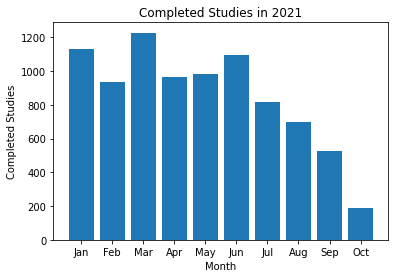

In [0]:
import matplotlib.pyplot as plt

# Create a list of x-labels and y-values
x_values = sortedcompletionDF.select('month').rdd.flatMap(lambda x: x).collect()
y_values = sortedcompletionDF.select('Completed Studies').rdd.flatMap(lambda x: x).collect()

# Create a bar graph
plt.bar(x_values, y_values)
plt.xlabel('Month')
plt.ylabel('Completed Studies')
plt.title('Completed Studies in 2021')

# Display the graph
plt.show()
